In [1]:
import random
import copy
import numpy as np
from itertools import combinations
from enum import Enum

###########################
# 枚举定义：动作与阶段
###########################
class Action(Enum):
    """
    定义可执行的动作：
    - FOLD: 弃牌
    - CALL: 跟注/看牌
    - RAISE: 加注
    """
    FOLD = 0
    CALL = 1
    RAISE = 2

class Stage(Enum):
    """
    定义游戏阶段，用于状态表示和阶段推进：
    - PREFLOP: 翻牌前
    - FLOP: 翻牌
    - TURN: 转牌
    - RIVER: 河牌
    - SHOWDOWN: 摊牌
    """
    PREFLOP = 0
    FLOP = 1
    TURN = 2
    RIVER = 3
    SHOWDOWN = 4

###########################
# 扑克牌评估函数
###########################
class Card:
    """
    表示一张扑克牌，包括点数和花色。
    """
    def __init__(self, rank, suit):
        self.rank = rank
        self.suit = suit
    def __repr__(self):
        return f"{self.rank}{self.suit}"


def create_deck():
    """
    生成并随机打乱一副标准 52 张扑克牌。
    返回列表形式的 Card 对象。
    """
    ranks = ['2','3','4','5','6','7','8','9','T','J','Q','K','A']
    suits = ['H','D','C','S']
    deck = [Card(r,s) for r in ranks for s in suits]
    random.shuffle(deck)
    return deck


def card_value(c):
    """
    将 Card.rank 转换为对应的数值，A 为最大 (14)。
    用于比较牌型大小。
    """
    order = {'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,
             'T':10,'J':11,'Q':12,'K':13,'A':14}
    return order[c.rank]


def check_straight(vals):
    """
    检查给定点数列表中是否存在顺子。
    返回 (是否顺子, 顺子最高点数)
    """
    vals = sorted(set(vals))
    if len(vals) < 5:
        return False, None
    for i in range(len(vals)-4):
        window = vals[i:i+5]
        if window[-1] - window[0] == 4:
            return True, window[-1]
    if {14,2,3,4,5}.issubset(vals):
        return True, 5
    return False, None


def evaluate_5card_hand(cards):
    """
    评估 5 张牌的手牌强度，返回元组。
    """
    vals = sorted([card_value(c) for c in cards], reverse=True)
    suits = [c.suit for c in cards]
    flush = len(set(suits)) == 1
    straight, high = check_straight(vals)
    freq = {v: vals.count(v) for v in vals}
    freq_sorted = sorted(freq.items(), key=lambda x:(x[1], x[0]), reverse=True)
    if flush and straight:
        return (8, high)
    if freq_sorted[0][1] == 4:
        four = freq_sorted[0][0]
        kick = max(v for v in vals if v != four)
        return (7, four, kick)
    if freq_sorted[0][1] == 3 and len(freq_sorted)>1 and freq_sorted[1][1]>=2:
        return (6, freq_sorted[0][0], freq_sorted[1][0])
    if flush:
        return (5, tuple(vals))
    if straight:
        return (4, high)
    if freq_sorted[0][1] == 3:
        kickers = sorted([v for v in vals if v != freq_sorted[0][0]], reverse=True)
        return (3, freq_sorted[0][0], tuple(kickers))
    if len(freq_sorted)>=2 and freq_sorted[0][1]==2 and freq_sorted[1][1]==2:
        p1,p2 = freq_sorted[0][0], freq_sorted[1][0]
        kick = max(v for v in vals if v not in (p1,p2))
        return (2, max(p1,p2), min(p1,p2), kick)
    if freq_sorted[0][1] == 2:
        kickers = sorted([v for v in vals if v != freq_sorted[0][0]], reverse=True)
        return (1, freq_sorted[0][0], tuple(kickers))
    return (0, tuple(vals))


def evaluate_hand(hole, community):
    """
    从 7 张牌选最佳 5 张，返回评估结果。
    """
    best = (-1,)
    for combo in combinations(hole+community, 5):
        rank = evaluate_5card_hand(combo)
        if rank > best:
            best = rank
    return best

###########################
# 自定义环境：1v1 有限注 德州扑克（不依赖 gym）
###########################
class TexasHoldemEnv:
    """
    纯 Python 实现的 Heads-up Limit 德州扑克环境，
    不依赖任何外部框架，只用 reset/step 接口。
    """
    def __init__(self, starting_chips=100, small_blind=1, big_blind=2, max_raises=4):
        # 初始筹码与盲注设置
        self.starting_chips = starting_chips
        self.small_blind = small_blind
        self.big_blind = big_blind
        self.max_raises = max_raises
        # 内部状态
        self.reset()

    def reset(self):
        """
        重置环境状态：洗牌、发二人手牌、初始化彩池与阶段。
        返回初始观测向量。
        """
        self.deck = create_deck()
        self.community_cards = []
        self.pot = self.small_blind + self.big_blind
        self.stage = Stage.PREFLOP
        self.raises_this_round = 0
        self.round_actions = 0
        self.player_cards = [self.deck.pop(), self.deck.pop()]
        self.opponent_cards = [self.deck.pop(), self.deck.pop()]
        self.betting_sequence = []
        return self._get_observation()

    def _get_observation(self):
        """
        构建观测向量：
        [阶段 one-hot] + [彩池] + [玩家底牌点数] + [公共牌数]
        """
        stage_oh = [0]*len(Stage)
        stage_oh[self.stage.value] = 1
        hole_vals = [card_value(c) for c in self.player_cards]
        comm_len = len(self.community_cards)
        return stage_oh + [self.pot] + hole_vals + [comm_len]

    def _get_legal_moves(self):
        """
        计算合法动作：始终允许弃牌和跟注，未超加注上限可加注。
        """
        moves = [Action.FOLD.value, Action.CALL.value]
        if self.raises_this_round < self.max_raises:
            moves.append(Action.RAISE.value)
        return moves

    def step(self, action):
        """
        执行动作，推进环境。
        返回 (obs, reward, done, info)。
        info 包含 'result': 'win'/'lose'/'draw'/'fold'.
        """
        # 合法性检查
        if action not in self._get_legal_moves():
            return self._get_observation(), -1.0, False, {'result':'illegal'}
        act = Action(action)
        reward, done, info = 0, False, {}
        # 弃牌
        if act == Action.FOLD:
            reward, done, info['result'] = -self.big_blind, True, 'fold'
        else:
            # 跟注或加注
            bet = self.small_blind if act == Action.CALL else self.big_blind
            self.pot += bet
            if act == Action.RAISE:
                self.raises_this_round += 1
            self.round_actions += 1
            self.betting_sequence.append((self.stage.name, act.name))
            # 阶段推进
            if self.round_actions >= 2:
                self.round_actions = 0
                if self.stage == Stage.RIVER:
                    self.stage = Stage.SHOWDOWN
                else:
                    self.stage = Stage(self.stage.value + 1)
                self.raises_this_round = 0
            # 摊牌结算
            if self.stage == Stage.SHOWDOWN:
                pr = evaluate_hand(self.player_cards, self.community_cards)
                orank = evaluate_hand(self.opponent_cards, self.community_cards)
                if pr > orank:
                    reward, info['result'] = self.pot, 'win'
                elif pr < orank:
                    reward, info['result'] = -self.pot, 'lose'
                else:
                    info['result'] = 'draw'
                done = True
        # 发公共牌
        if not done and self.stage in (Stage.FLOP, Stage.TURN, Stage.RIVER) and self.round_actions == 0:
            if self.stage == Stage.FLOP:
                for _ in range(3): self.community_cards.append(self.deck.pop())
            else:
                self.community_cards.append(self.deck.pop())
        return self._get_observation(), reward, done, info

    def clone(self):
        """
        返回深拷贝，用于无副作用的模拟。
        """
        return copy.deepcopy(self)

if __name__ == '__main__':
    env = TexasHoldemEnv()
    obs = env.reset()
    print('Obs:', obs)
    obs, r, d, i = env.step(Action.CALL.value)

Obs: [1, 0, 0, 0, 0, 3, 4, 9, 0]


训练CFR代理 (iterations=1000)...
训练 CFR 代理...
CFR Iteration 100/1000, Utility: -0.417
CFR Iteration 200/1000, Utility: -0.469
CFR Iteration 300/1000, Utility: -0.417
CFR Iteration 400/1000, Utility: -0.740
CFR Iteration 500/1000, Utility: -0.417
CFR Iteration 600/1000, Utility: -0.417
CFR Iteration 700/1000, Utility: -0.417
CFR Iteration 800/1000, Utility: 0.190
CFR Iteration 900/1000, Utility: -0.469
CFR Iteration 1000/1000, Utility: 0.190
训练完成，共生成 14111 个信息集
模拟 100 场游戏...


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]
<ipython-input-4-a339ab14c240>:815: UserWarning: Glyph 28216 (\N{CJK UNIFIED IDEOGRAPH-6E38}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-a339ab14c240>:815: UserWarning: Glyph 25103 (\N{CJK UNIFIED IDEOGRAPH-620F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-a339ab14c240>:815: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-a339ab14c240>:815: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-a339ab14c240>:815: UserWarning: Glyph 32988 (\N{CJK UNIFIED IDEOGRAPH-80DC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-a339ab14c240>:815: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-a339ab14c240>:815: UserWarning: Glyph 1


100 场游戏结果汇总:
CFR Agent 获胜: 10 (10.0%)
Equity Agent 获胜: 89 (89.0%)
平局: 1 (1.0%)

不考虑平局的胜率:
CFR Agent: 10.1%
Equity Agent: 89.9%


<ipython-input-4-a339ab14c240>:816: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from font(s) DejaVu Sans.
  plt.savefig('poker_agent_winrates.png')
<ipython-input-4-a339ab14c240>:816: UserWarning: Glyph 26395 (\N{CJK UNIFIED IDEOGRAPH-671B}) missing from font(s) DejaVu Sans.
  plt.savefig('poker_agent_winrates.png')
<ipython-input-4-a339ab14c240>:816: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from font(s) DejaVu Sans.
  plt.savefig('poker_agent_winrates.png')
<ipython-input-4-a339ab14c240>:816: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from font(s) DejaVu Sans.
  plt.savefig('poker_agent_winrates.png')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35745 (\N{CJK UNIFIED I

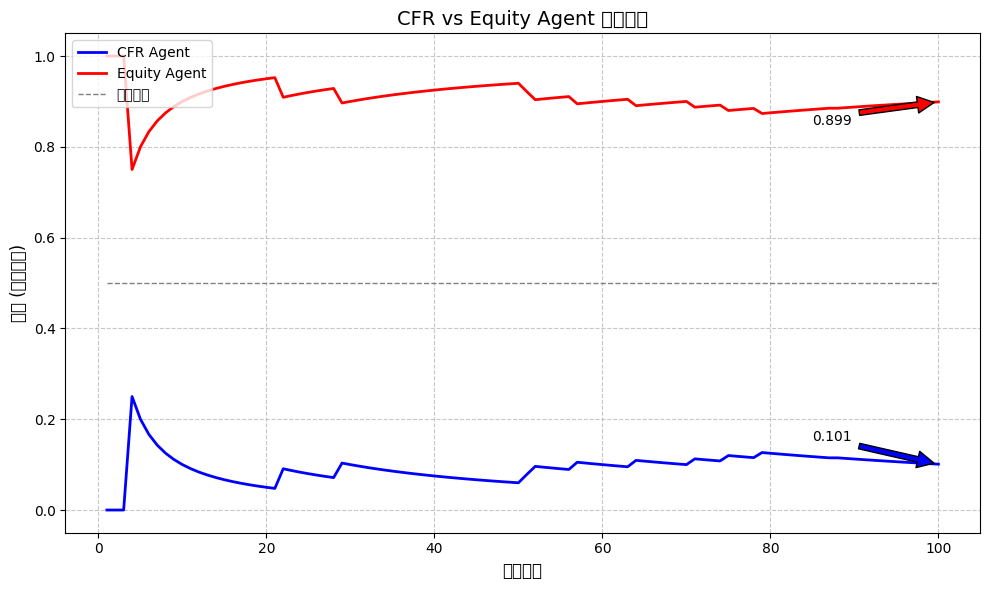

In [4]:
# @title 德州扑克AI对决：CFR vs Equity Agent

# 安装必要的依赖
!pip install tqdm matplotlib numpy -q

import random
import copy
import numpy as np
from itertools import combinations
from enum import Enum
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

###########################
# 枚举定义：动作与阶段
###########################
class Action(Enum):
    """
    定义可执行的动作：
    - FOLD: 弃牌
    - CALL: 跟注/看牌
    - RAISE: 加注
    """
    FOLD = 0
    CALL = 1
    RAISE = 2

class Stage(Enum):
    """
    定义游戏阶段，用于状态表示和阶段推进：
    - PREFLOP: 翻牌前
    - FLOP: 翻牌
    - TURN: 转牌
    - RIVER: 河牌
    - SHOWDOWN: 摊牌
    """
    PREFLOP = 0
    FLOP = 1
    TURN = 2
    RIVER = 3
    SHOWDOWN = 4

###########################
# 扑克牌评估函数
###########################
class Card:
    """
    表示一张扑克牌，包括点数和花色。
    """
    def __init__(self, rank, suit):
        self.rank = rank
        self.suit = suit
    def __repr__(self):
        return f"{self.rank}{self.suit}"


def create_deck():
    """
    生成并随机打乱一副标准 52 张扑克牌。
    返回列表形式的 Card 对象。
    """
    ranks = ['2','3','4','5','6','7','8','9','T','J','Q','K','A']
    suits = ['H','D','C','S']
    deck = [Card(r,s) for r in ranks for s in suits]
    random.shuffle(deck)
    return deck


def card_value(c):
    """
    将 Card.rank 转换为对应的数值，A 为最大 (14)。
    用于比较牌型大小。
    """
    order = {'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,
             'T':10,'J':11,'Q':12,'K':13,'A':14}
    return order[c.rank]


def check_straight(vals):
    """
    检查给定点数列表中是否存在顺子。
    返回 (是否顺子, 顺子最高点数)
    """
    vals = sorted(set(vals))
    if len(vals) < 5:
        return False, None
    for i in range(len(vals)-4):
        window = vals[i:i+5]
        if window[-1] - window[0] == 4:
            return True, window[-1]
    if {14,2,3,4,5}.issubset(vals):
        return True, 5
    return False, None


def evaluate_5card_hand(cards):
    """
    评估 5 张牌的手牌强度，返回元组。
    """
    vals = sorted([card_value(c) for c in cards], reverse=True)
    suits = [c.suit for c in cards]
    flush = len(set(suits)) == 1
    straight, high = check_straight(vals)
    freq = {v: vals.count(v) for v in vals}
    freq_sorted = sorted(freq.items(), key=lambda x:(x[1], x[0]), reverse=True)
    if flush and straight:
        return (8, high)
    if freq_sorted[0][1] == 4:
        four = freq_sorted[0][0]
        kick = max(v for v in vals if v != four)
        return (7, four, kick)
    if freq_sorted[0][1] == 3 and len(freq_sorted)>1 and freq_sorted[1][1]>=2:
        return (6, freq_sorted[0][0], freq_sorted[1][0])
    if flush:
        return (5, tuple(vals))
    if straight:
        return (4, high)
    if freq_sorted[0][1] == 3:
        kickers = sorted([v for v in vals if v != freq_sorted[0][0]], reverse=True)
        return (3, freq_sorted[0][0], tuple(kickers))
    if len(freq_sorted)>=2 and freq_sorted[0][1]==2 and freq_sorted[1][1]==2:
        p1,p2 = freq_sorted[0][0], freq_sorted[1][0]
        kick = max(v for v in vals if v not in (p1,p2))
        return (2, max(p1,p2), min(p1,p2), kick)
    if freq_sorted[0][1] == 2:
        kickers = sorted([v for v in vals if v != freq_sorted[0][0]], reverse=True)
        return (1, freq_sorted[0][0], tuple(kickers))
    return (0, tuple(vals))


def evaluate_hand(hole, community):
    """
    从 7 张牌选最佳 5 张，返回评估结果。
    """
    best = (-1,)
    for combo in combinations(hole+community, 5):
        rank = evaluate_5card_hand(combo)
        if rank > best:
            best = rank
    return best

###########################
# 自定义环境：1v1 有限注 德州扑克（不依赖 gym）
###########################
class TexasHoldemEnv:
    """
    纯 Python 实现的 Heads-up Limit 德州扑克环境，
    不依赖任何外部框架，只用 reset/step 接口。
    """
    def __init__(self, starting_chips=100, small_blind=1, big_blind=2, max_raises=4):
        # 初始筹码与盲注设置
        self.starting_chips = starting_chips
        self.small_blind = small_blind
        self.big_blind = big_blind
        self.max_raises = max_raises
        # 内部状态
        self.reset()

    def reset(self):
        """
        重置环境状态：洗牌、发二人手牌、初始化彩池与阶段。
        返回初始观测向量。
        """
        self.deck = create_deck()
        self.community_cards = []
        self.pot = self.small_blind + self.big_blind
        self.stage = Stage.PREFLOP
        self.raises_this_round = 0
        self.round_actions = 0
        self.player_cards = [self.deck.pop(), self.deck.pop()]
        self.opponent_cards = [self.deck.pop(), self.deck.pop()]
        self.betting_sequence = []
        return self._get_observation()

    def _get_observation(self):
        """
        构建观测向量：
        [阶段 one-hot] + [彩池] + [玩家底牌点数] + [公共牌数]
        """
        stage_oh = [0]*len(Stage)
        stage_oh[self.stage.value] = 1
        hole_vals = [card_value(c) for c in self.player_cards]
        comm_len = len(self.community_cards)
        return stage_oh + [self.pot] + hole_vals + [comm_len]

    def _get_legal_moves(self):
        """
        计算合法动作：始终允许弃牌和跟注，未超加注上限可加注。
        """
        moves = [Action.FOLD.value, Action.CALL.value]
        if self.raises_this_round < self.max_raises:
            moves.append(Action.RAISE.value)
        return moves

    def step(self, action):
        """
        执行动作，推进环境。
        返回 (obs, reward, done, info)。
        info 包含 'result': 'win'/'lose'/'draw'/'fold'.
        """
        # 合法性检查
        if action not in self._get_legal_moves():
            return self._get_observation(), -1.0, False, {'result':'illegal'}
        act = Action(action)
        reward, done, info = 0, False, {}

        # 记录玩家动作
        info['player_action'] = act.name

        # 弃牌
        if act == Action.FOLD:
            reward, done, info['result'] = -self.big_blind, True, 'fold'
        else:
            # 跟注或加注
            bet = self.small_blind if act == Action.CALL else self.big_blind
            self.pot += bet
            if act == Action.RAISE:
                self.raises_this_round += 1
            self.round_actions += 1
            self.betting_sequence.append((self.stage.name, act.name))
            # 阶段推进
            if self.round_actions >= 2:
                self.round_actions = 0
                if self.stage == Stage.RIVER:
                    self.stage = Stage.SHOWDOWN
                else:
                    self.stage = Stage(self.stage.value + 1)
                self.raises_this_round = 0
            # 摊牌结算
            if self.stage == Stage.SHOWDOWN:
                pr = evaluate_hand(self.player_cards, self.community_cards)
                orank = evaluate_hand(self.opponent_cards, self.community_cards)
                if pr > orank:
                    reward, info['result'] = self.pot, 'win'
                elif pr < orank:
                    reward, info['result'] = -self.pot, 'lose'
                else:
                    info['result'] = 'draw'
                done = True
        # 发公共牌
        if not done and self.stage in (Stage.FLOP, Stage.TURN, Stage.RIVER) and self.round_actions == 0:
            if self.stage == Stage.FLOP:
                for _ in range(3): self.community_cards.append(self.deck.pop())
            else:
                self.community_cards.append(self.deck.pop())
        return self._get_observation(), reward, done, info

    def clone(self):
        """
        返回深拷贝，用于无副作用的模拟。
        """
        return copy.deepcopy(self)

    def render(self):
        """
        简单打印当前游戏状态
        """
        print(f"Stage: {self.stage.name}")
        print(f"Pot: {self.pot}")
        print(f"Player cards: {self.player_cards}")
        print(f"Community cards: {self.community_cards}")
        if self.stage == Stage.SHOWDOWN:
            print(f"Opponent cards: {self.opponent_cards}")
        print(f"Betting sequence: {self.betting_sequence}")
        print("-" * 40)

#################################
# 蒙特卡洛模拟求期望胜率（Equity）
#################################
def get_equity(player_cards, community_cards, opponent_cards=None, runs=1000):
    """
    通过蒙特卡洛模拟计算当前手牌获胜的概率

    参数:
    - player_cards: 玩家手牌
    - community_cards: 公共牌
    - opponent_cards: 已知的对手手牌，为 None 时随机模拟
    - runs: 模拟次数

    返回:
    - 预计胜率 (0-1之间的浮点数)
    """
    wins = 0
    draws = 0

    # 创建扑克牌副本，用于抽牌
    ranks = ['2','3','4','5','6','7','8','9','T','J','Q','K','A']
    suits = ['H','D','C','S']

    # 移除已知卡牌
    available_cards = []
    for r in ranks:
        for s in suits:
            card = Card(r, s)
            # 检查卡是否已经在玩家手牌或公共牌中
            in_player = any(c.rank == card.rank and c.suit == card.suit for c in player_cards)
            in_community = any(c.rank == card.rank and c.suit == card.suit for c in community_cards)
            in_opponent = False
            if opponent_cards:
                in_opponent = any(c.rank == card.rank and c.suit == card.suit for c in opponent_cards)

            if not (in_player or in_community or in_opponent):
                available_cards.append(card)

    for _ in range(runs):
        # 随机抽选对手手牌
        if opponent_cards is None:
            random.shuffle(available_cards)
            opp_cards = available_cards[:2]
            remaining = available_cards[2:]
        else:
            opp_cards = opponent_cards
            remaining = available_cards.copy()

        # 补齐公共牌至5张
        random.shuffle(remaining)
        simulated_community = community_cards.copy()
        cards_needed = 5 - len(simulated_community)
        if cards_needed > 0:
            simulated_community.extend(remaining[:cards_needed])

        # 计算牌型强度
        player_rank = evaluate_hand(player_cards, simulated_community)
        opponent_rank = evaluate_hand(opp_cards, simulated_community)

        # 判断胜负
        if player_rank > opponent_rank:
            wins += 1
        elif player_rank == opponent_rank:
            draws += 1

    # 计算胜率，将平局算作半胜
    return (wins + 0.5 * draws) / runs

#################################
# Equity-Based Agent 基于胜率的代理
#################################
class EquityAgent:
    """
    基于胜率 (Equity) 的德州扑克AI代理
    根据预设的阈值策略做出决策
    """
    def __init__(self, min_call_equity=0.4, min_bet_equity=0.6, delta1=0.1, delta2=0.2):
        # 设置阈值参数
        self.min_call_equity = min_call_equity  # T_call
        self.min_bet_equity = min_bet_equity    # T_bet
        self.delta1 = delta1                   # δ1
        self.delta2 = delta2                   # δ2

    def act(self, env, verbose=False):
        """
        根据阈值策略决定下一步动作
        """
        # 获取当前环境状态
        observation = env._get_observation()
        legal_moves = env._get_legal_moves()

        # 计算当前手牌的预期胜率
        equity = get_equity(env.player_cards, env.community_cards, runs=1000)

        # 创建决策日志
        log_entry = f"[Equity={equity:.2f}] "

        # 根据阈值策略决定动作
        action = None

        # 按照优先级从高到低决定动作：
        # 1. 如果 E > T_bet + δ2 且 ALL_IN 合法: ALL_IN
        if equity > self.min_bet_equity + self.delta2 and Action.RAISE.value in legal_moves:
            action = Action.RAISE.value
            log_entry += "→ ALL_IN"

        # 2. 如果 E > T_bet + δ1 且 RAISE_2POT 合法: RAISE_2POT
        elif equity > self.min_bet_equity + self.delta1 and Action.RAISE.value in legal_moves:
            action = Action.RAISE.value
            log_entry += "→ RAISE_2POT"

        # 3. 如果 E > T_bet 且 RAISE_POT 合法: RAISE_POT
        elif equity > self.min_bet_equity and Action.RAISE.value in legal_moves:
            action = Action.RAISE.value
            log_entry += "→ RAISE_POT"

        # 4. 如果 E > T_bet - δ1 且 RAISE_HALF_POT 合法: RAISE_HALF_POT
        elif equity > self.min_bet_equity - self.delta1 and Action.RAISE.value in legal_moves:
            action = Action.RAISE.value
            log_entry += "→ RAISE_HALF_POT"

        # 5. 如果 E > T_call 且 CALL 合法: CALL
        elif equity > self.min_call_equity and Action.CALL.value in legal_moves:
            action = Action.CALL.value
            log_entry += "→ CALL"

        # 6. 如果 CHECK 合法: CHECK (在这个环境中，CHECK 等同于 CALL)
        elif Action.CALL.value in legal_moves:
            action = Action.CALL.value
            log_entry += "→ CHECK"

        # 7. 否则: FOLD
        else:
            action = Action.FOLD.value
            log_entry += "→ FOLD"

        if verbose:
            print(f"Equity Agent: {log_entry}")

        return action

#################################
# CFR Agent (Counterfactual Regret Minimization)
#################################
class InfoSet:
    """
    信息集：代表游戏中的一个决策点
    用于CFR算法中保存策略与遗憾值
    """
    def __init__(self, num_actions=3):
        self.num_actions = num_actions
        self.regret_sum = np.zeros(num_actions)
        self.strategy_sum = np.zeros(num_actions)
        self.num_visits = 0

    def get_strategy(self, reach_prob):
        """
        根据累积遗憾计算当前策略
        """
        # 正则化 regret 值得到概率
        regrets = np.maximum(self.regret_sum, 0)
        regret_sum = np.sum(regrets)

        if regret_sum > 0:
            strategy = regrets / regret_sum
        else:
            # 如果所有动作的遗憾都为0，使用均匀策略
            strategy = np.ones(self.num_actions) / self.num_actions

        # 累加加权策略以计算平均策略
        self.strategy_sum += reach_prob * strategy
        self.num_visits += 1

        return strategy

    def get_average_strategy(self):
        """
        获取平均策略，作为最终博弈解
        """
        if np.sum(self.strategy_sum) == 0:
            return np.ones(self.num_actions) / self.num_actions

        # 返回标准化的平均策略
        return self.strategy_sum / np.sum(self.strategy_sum)

class CFRAgent:
    """
    使用简化版 CFR 算法的德州扑克AI代理
    """
    def __init__(self, iterations=1000):
        # 训练迭代次数
        self.iterations = iterations

        # 信息集字典：映射状态 -> 信息集
        self.info_sets = {}

        # 对局历史数据
        self.action_history = []

        # 训练CFR
        self.train()

    def get_info_key(self, env):
        """
        将当前环境状态转换为信息集键
        这里使用了简化表示，实际应用中可能需要更详细的状态编码
        """
        # 提取关键信息：阶段、手牌、公共牌
        stage = env.stage.name
        player_cards = "".join(str(c) for c in sorted(env.player_cards, key=lambda x: (card_value(x), x.suit)))
        community = "".join(str(c) for c in sorted(env.community_cards, key=lambda x: (card_value(x), x.suit)))
        bet_history = "_".join([a for _, a in env.betting_sequence[-2:]] if env.betting_sequence else [])

        return f"{stage}|{player_cards}|{community}|{bet_history}"

    def train(self):
        """
        使用CFR算法训练策略
        """
        print("训练 CFR 代理...")
        utilities = []

        for i in range(self.iterations):
            # 创建新的环境实例
            env = TexasHoldemEnv()
            env.reset()

            # 执行CFR迭代
            util = self._cfr(env, 1, 1)
            utilities.append(util)

            if (i+1) % (self.iterations // 10) == 0:
                print(f"CFR Iteration {i+1}/{self.iterations}, Utility: {util:.3f}")

        # 打印信息集数量
        print(f"训练完成，共生成 {len(self.info_sets)} 个信息集")

    def _cfr(self, env, p0, p1):
        """
        递归执行CFR算法

        参数:
        - env: 当前环境状态
        - p0: 达到当前信息集的玩家概率
        - p1: 达到当前信息集的对手概率

        返回:
        - 当前节点的效用值
        """
        # 检查游戏是否结束
        if env.stage == Stage.SHOWDOWN:
            pr = evaluate_hand(env.player_cards, env.community_cards)
            orank = evaluate_hand(env.opponent_cards, env.community_cards)
            if pr > orank:
                return 1  # 玩家获胜
            elif pr < orank:
                return -1  # 对手获胜
            else:
                return 0  # 平局

        # 获取当前信息集
        info_key = self.get_info_key(env)

        # 获取合法动作
        legal_moves = env._get_legal_moves()

        if info_key not in self.info_sets:
            self.info_sets[info_key] = InfoSet(len(Action))

        info_set = self.info_sets[info_key]

        # 获取当前策略
        strategy = info_set.get_strategy(p0)

        # 为每个动作计算反事实值
        counterfactual_values = np.zeros(len(Action))

        for action in legal_moves:
            # 克隆环境以进行模拟
            next_env = env.clone()

            # 执行动作
            _, reward, done, info = next_env.step(action)

            action_prob = strategy[action]

            if done:
                # 如果游戏结束，计算立即回报
                if info['result'] == 'win':
                    counterfactual_values[action] = 1
                elif info['result'] == 'lose':
                    counterfactual_values[action] = -1
                elif info['result'] == 'fold':
                    counterfactual_values[action] = -1
                else:  # 'draw'
                    counterfactual_values[action] = 0
            else:
                # 否则递归计算
                new_p0 = p1
                new_p1 = p0 * action_prob

                counterfactual_values[action] = -self._cfr(next_env, new_p0, new_p1)

        # 计算期望值
        node_value = 0
        for action in legal_moves:
            node_value += strategy[action] * counterfactual_values[action]

        # 更新遗憾
        for action in legal_moves:
            regret = counterfactual_values[action] - node_value
            info_set.regret_sum[action] += p1 * regret

        return node_value

    def act(self, env, verbose=False):
        """
        根据已学习的策略决定下一步动作
        """
        # 获取当前环境状态
        legal_moves = env._get_legal_moves()

        # 获取信息集
        info_key = self.get_info_key(env)

        if verbose:
            print(f"CFR Agent info key: {info_key}")

        if info_key in self.info_sets:
            # 获取该信息集的平均策略
            strategy = self.info_sets[info_key].get_average_strategy()

            # 从策略中选择动作
            action_probs = np.zeros(len(legal_moves))
            for i, action in enumerate(legal_moves):
                action_probs[i] = strategy[action]

            # 归一化概率
            if np.sum(action_probs) > 0:
                action_probs = action_probs / np.sum(action_probs)

                # 以最高概率选择动作，加入一定探索
                if random.random() < 0.9:  # 90% 采用策略
                    action = np.random.choice(legal_moves, p=action_probs)
                else:  # 10% 随机探索
                    action = random.choice(legal_moves)
            else:
                action = random.choice(legal_moves)

            if verbose:
                act_name = Action(action).name
                print(f"CFR Agent: 选择动作 {act_name} (策略概率: {strategy})")
        else:
            # 如果信息集不存在，使用随机策略
            action = random.choice(legal_moves)
            if verbose:
                print(f"CFR Agent: 信息集未知，随机选择动作 {Action(action).name}")

        # 记录动作历史
        self.action_history.append((info_key, action))

        return action

#################################
# 模拟对局
#################################
def simulate_games(num_games=100, verbose=False):
    """
    模拟CFR与Equity Agent之间的多场对局
    """
    print(f"训练CFR代理 (iterations={CFR_ITERATIONS})...")
    cfr_agent = CFRAgent(iterations=CFR_ITERATIONS)
    equity_agent = EquityAgent(min_call_equity=0.4, min_bet_equity=0.6)

    print(f"模拟 {num_games} 场游戏...")

    # 记录胜负结果
    results = {
        'cfr_wins': 0,
        'equity_wins': 0,
        'draws': 0,
        'total_games': 0,
        'completed_games': 0  # 不包括平局的已完成游戏
    }

    # 记录每场比赛后的胜率
    cfr_winrate_history = []

    for i in tqdm(range(num_games)):
        # 创建新环境
        env = TexasHoldemEnv()
        env.reset()

        # 决定先后手 (交替)
        if i % 2 == 0:
            first_agent, second_agent = cfr_agent, equity_agent
            first_name, second_name = "CFR", "Equity"
        else:
            first_agent, second_agent = equity_agent, cfr_agent
            first_name, second_name = "Equity", "CFR"

        done = False

        if verbose:
            print(f"\nGame {i+1}: {first_name} vs {second_name}")
            print(f"Player cards: {env.player_cards}")
            print(f"Opponent cards: {env.opponent_cards}")

        while not done:
            # 第一位玩家行动
            action = first_agent.act(env, verbose=verbose)
            _, reward, done, info = env.step(action)

            if verbose:
                print(f"{first_name} 选择: {info['player_action']}")
                if 'result' in info:
                    print(f"结果: {info['result']}")

            if done:
                if info['result'] == 'win':
                    results['total_games'] += 1
                    results['completed_games'] += 1
                    if first_name == "CFR":
                        results['cfr_wins'] += 1
                    else:
                        results['equity_wins'] += 1
                elif info['result'] == 'lose':
                    results['total_games'] += 1
                    results['completed_games'] += 1
                    if first_name == "CFR":
                        results['equity_wins'] += 1
                    else:
                        results['cfr_wins'] += 1
                elif info['result'] == 'draw':
                    results['total_games'] += 1
                    results['draws'] += 1
                elif info['result'] == 'fold':
                    results['total_games'] += 1
                    results['completed_games'] += 1
                    if first_name == "CFR":  # CFR弃牌，Equity赢
                        results['equity_wins'] += 1
                    else:  # Equity弃牌，CFR赢
                        results['cfr_wins'] += 1
                break

            # 第二位玩家行动
            action = second_agent.act(env, verbose=verbose)
            _, reward, done, info = env.step(action)

            if verbose:
                print(f"{second_name} 选择: {info['player_action']}")
                if 'result' in info:
                    print(f"结果: {info['result']}")

                # 阶段完成后显示公共牌
                if env.stage == Stage.FLOP:
                    print(f"翻牌: {env.community_cards}")
                elif env.stage == Stage.TURN:
                    print(f"转牌: {env.community_cards[-1]}")
                elif env.stage == Stage.RIVER:
                    print(f"河牌: {env.community_cards[-1]}")

            if done:
                if info['result'] == 'win':
                    results['total_games'] += 1
                    results['completed_games'] += 1
                    if second_name == "CFR":
                        results['cfr_wins'] += 1
                    else:
                        results['equity_wins'] += 1
                elif info['result'] == 'lose':
                    results['total_games'] += 1
                    results['completed_games'] += 1
                    if second_name == "CFR":
                        results['equity_wins'] += 1
                    else:
                        results['cfr_wins'] += 1
                elif info['result'] == 'draw':
                    results['total_games'] += 1
                    results['draws'] += 1
                elif info['result'] == 'fold':
                    results['total_games'] += 1
                    results['completed_games'] += 1
                    if second_name == "CFR":  # CFR弃牌，Equity赢
                        results['equity_wins'] += 1
                    else:  # Equity弃牌，CFR赢
                        results['cfr_wins'] += 1

                if verbose and info['result'] != 'fold':
                    print(f"摊牌: 玩家 {env.player_cards}, 对手 {env.opponent_cards}")
                    print(f"公共牌: {env.community_cards}")
                    print(f"结果: {info['result']}")

        # 计算CFR的胜率 (不考虑平局)
        if results['completed_games'] > 0:
            cfr_winrate = results['cfr_wins'] / results['completed_games']
        else:
            cfr_winrate = 0.5  # 默认为0.5

        cfr_winrate_history.append(cfr_winrate)

    # 汇总结果
    print(f"\n{num_games} 场游戏结果汇总:")
    print(f"CFR Agent 获胜: {results['cfr_wins']} ({results['cfr_wins']/results['total_games']*100:.1f}%)")
    print(f"Equity Agent 获胜: {results['equity_wins']} ({results['equity_wins']/results['total_games']*100:.1f}%)")
    print(f"平局: {results['draws']} ({results['draws']/results['total_games']*100:.1f}%)")

    if results['completed_games'] > 0:
        print(f"\n不考虑平局的胜率:")
        print(f"CFR Agent: {results['cfr_wins']/results['completed_games']*100:.1f}%")
        print(f"Equity Agent: {results['equity_wins']/results['completed_games']*100:.1f}%")

    return cfr_winrate_history, results

#################################
# 可视化结果
#################################
def plot_results(cfr_winrate_history, results):
    """
    绘制胜率随对局数的变化图
    """
    plt.figure(figsize=(10, 6))

    games = list(range(1, len(cfr_winrate_history) + 1))

    plt.plot(games, cfr_winrate_history, label='CFR Agent', color='blue', linewidth=2)
    plt.plot(games, [1 - rate for rate in cfr_winrate_history], label='Equity Agent', color='red', linewidth=2)
    plt.plot(games, [0.5] * len(games), '--', color='gray', label='期望随机', linewidth=1)

    plt.xlabel('游戏数量', fontsize=12)
    plt.ylabel('胜率 (不计平局)', fontsize=12)
    plt.title('CFR vs Equity Agent 对战胜率', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # 添加终局胜率标注
    final_cfr = cfr_winrate_history[-1]
    final_equity = 1 - final_cfr

    plt.annotate(f'{final_cfr:.3f}', xy=(len(games), final_cfr),
                 xytext=(len(games)-15, final_cfr+0.05),
                 arrowprops=dict(facecolor='blue', shrink=0.05), fontsize=10)

    plt.annotate(f'{final_equity:.3f}', xy=(len(games), final_equity),
                 xytext=(len(games)-15, final_equity-0.05),
                 arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10)

    plt.tight_layout()
    plt.savefig('poker_agent_winrates.png')
    plt.show()

# 可选参数设置
CFR_ITERATIONS = 1000  # CFR训练迭代次数
NUM_GAMES = 100        # 模拟对局数量
VERBOSE = False        # 是否显示详细对局过程

# 运行模拟对局
cfr_history, results = simulate_games(num_games=NUM_GAMES, verbose=VERBOSE)

# 可视化结果
plot_results(cfr_history, results)

初始化代理...
训练 CFR 代理...
CFR Iteration 100/1000, Utility: -0.417
CFR Iteration 200/1000, Utility: 0.083
CFR Iteration 300/1000, Utility: 0.083
CFR Iteration 400/1000, Utility: -0.417
CFR Iteration 500/1000, Utility: -0.672
CFR Iteration 600/1000, Utility: 0.083
CFR Iteration 700/1000, Utility: 0.083
CFR Iteration 800/1000, Utility: -0.417
CFR Iteration 900/1000, Utility: 0.083
CFR Iteration 1000/1000, Utility: -0.502
训练完成，共生成 14046 个信息集

=== CFR vs Equity 对战 ===
模拟 100 场游戏: CFR vs Equity...


100%|██████████| 100/100 [01:00<00:00,  1.66it/s]



100 场游戏结果汇总 (CFR vs Equity):
CFR 获胜: 8 (8.0%)
Equity 获胜: 92 (92.0%)
平局: 0 (0.0%)

不考虑平局的胜率:
CFR: 8.0%
Equity: 92.0%

=== CFR vs Random 对战 ===
模拟 100 场游戏: CFR vs Random...


100%|██████████| 100/100 [00:00<00:00, 5727.73it/s]



100 场游戏结果汇总 (CFR vs Random):
CFR 获胜: 48 (48.0%)
Random 获胜: 52 (52.0%)
平局: 0 (0.0%)

不考虑平局的胜率:
CFR: 48.0%
Random: 52.0%

=== Equity vs Random 对战 ===
模拟 100 场游戏: Equity vs Random...


100%|██████████| 100/100 [01:08<00:00,  1.47it/s]
<ipython-input-1-c1f60929297d>:840: UserWarning: Glyph 28216 (\N{CJK UNIFIED IDEOGRAPH-6E38}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-1-c1f60929297d>:840: UserWarning: Glyph 25103 (\N{CJK UNIFIED IDEOGRAPH-620F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-1-c1f60929297d>:840: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-1-c1f60929297d>:840: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-1-c1f60929297d>:840: UserWarning: Glyph 32988 (\N{CJK UNIFIED IDEOGRAPH-80DC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-1-c1f60929297d>:840: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-1-c1f60929297d>:840: UserWarning: Glyph 1


100 场游戏结果汇总 (Equity vs Random):
Equity 获胜: 86 (86.0%)
Random 获胜: 14 (14.0%)
平局: 0 (0.0%)

不考虑平局的胜率:
Equity: 86.0%
Random: 14.0%

生成胜率图表...


<ipython-input-1-c1f60929297d>:841: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{agent1_name}_vs_{agent2_name}_winrates.png')
<ipython-input-1-c1f60929297d>:841: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{agent1_name}_vs_{agent2_name}_winrates.png')
<ipython-input-1-c1f60929297d>:841: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{agent1_name}_vs_{agent2_name}_winrates.png')
<ipython-input-1-c1f60929297d>:841: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{agent1_name}_vs_{agent2_name}_winrates.png')
<ipython-input-1-c1f60929297d>:841: UserWarning: Glyph 23616 (\N{CJK UNIFIED IDEOGRAPH-5C40}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{agent1_name}_vs_{agent2_name}_winrates.png')
<ipython-input-1-c1f60929297d>:841: UserWarning: G

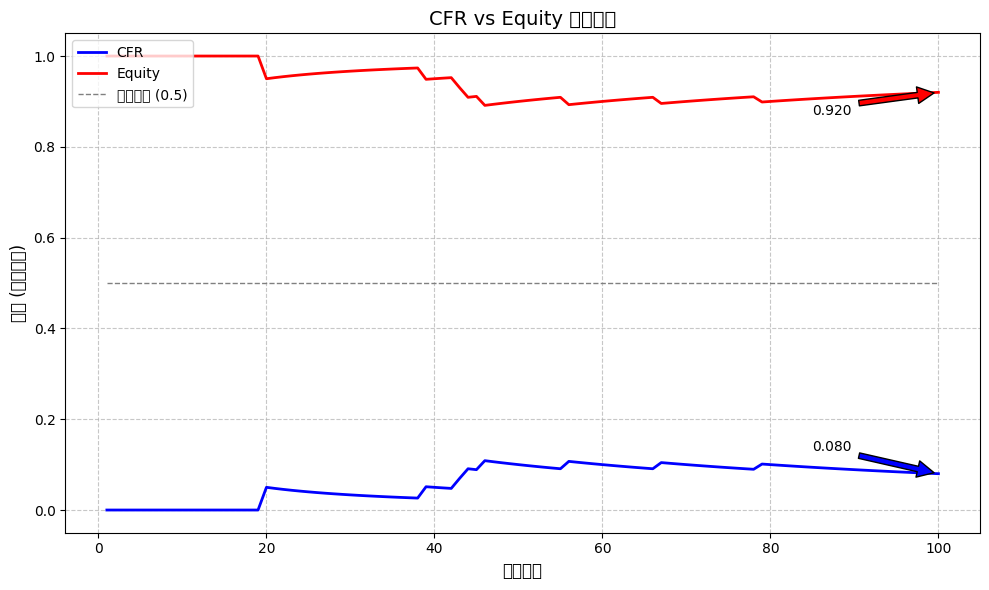

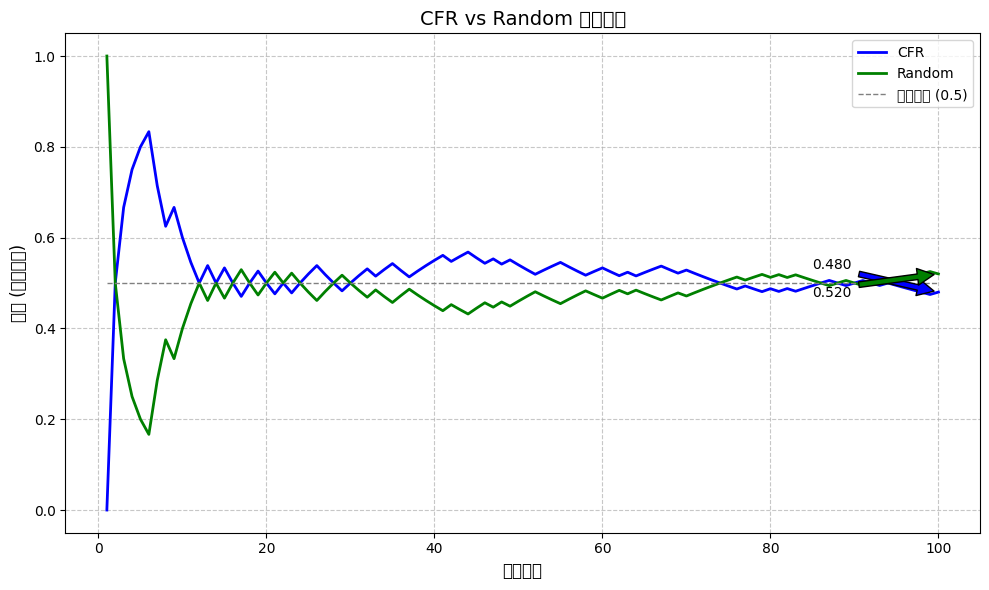

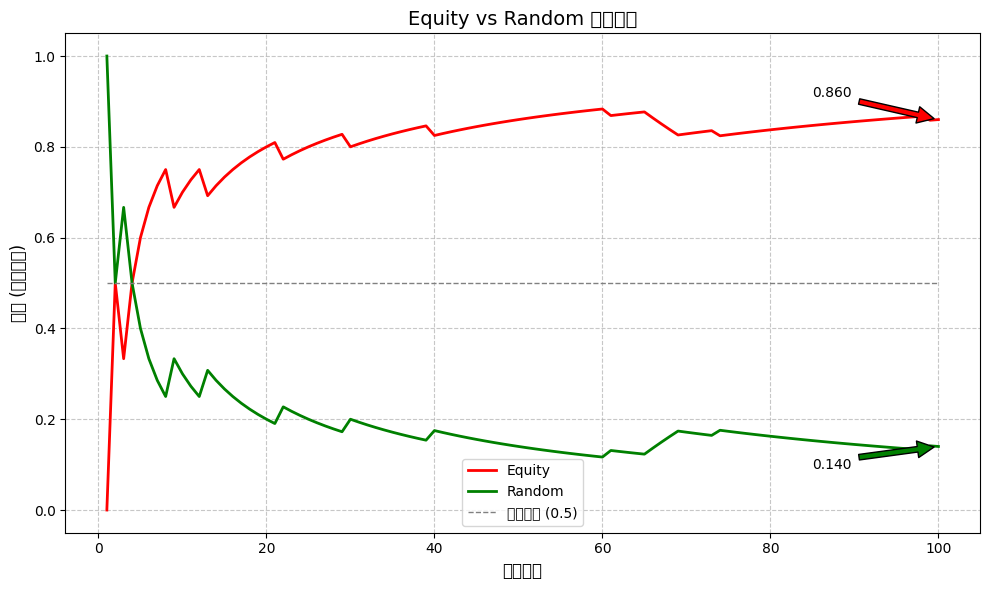


所有模拟完成！


In [1]:
# @title 德州扑克AI对决：CFR、Equity和Random代理

# 安装必要的依赖
!pip install tqdm matplotlib numpy -q

import random
import copy
import numpy as np
from itertools import combinations
from enum import Enum
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

###########################
# 枚举定义：动作与阶段
###########################
class Action(Enum):
    """
    定义可执行的动作：
    - FOLD: 弃牌
    - CALL: 跟注/看牌
    - RAISE: 加注
    """
    FOLD = 0
    CALL = 1
    RAISE = 2

class Stage(Enum):
    """
    定义游戏阶段，用于状态表示和阶段推进：
    - PREFLOP: 翻牌前
    - FLOP: 翻牌
    - TURN: 转牌
    - RIVER: 河牌
    - SHOWDOWN: 摊牌
    """
    PREFLOP = 0
    FLOP = 1
    TURN = 2
    RIVER = 3
    SHOWDOWN = 4

###########################
# 扑克牌评估函数
###########################
class Card:
    """
    表示一张扑克牌，包括点数和花色。
    """
    def __init__(self, rank, suit):
        self.rank = rank
        self.suit = suit
    def __repr__(self):
        return f"{self.rank}{self.suit}"


def create_deck():
    """
    生成并随机打乱一副标准 52 张扑克牌。
    返回列表形式的 Card 对象。
    """
    ranks = ['2','3','4','5','6','7','8','9','T','J','Q','K','A']
    suits = ['H','D','C','S']
    deck = [Card(r,s) for r in ranks for s in suits]
    random.shuffle(deck)
    return deck


def card_value(c):
    """
    将 Card.rank 转换为对应的数值，A 为最大 (14)。
    用于比较牌型大小。
    """
    order = {'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,
             'T':10,'J':11,'Q':12,'K':13,'A':14}
    return order[c.rank]


def check_straight(vals):
    """
    检查给定点数列表中是否存在顺子。
    返回 (是否顺子, 顺子最高点数)
    """
    vals = sorted(set(vals))
    if len(vals) < 5:
        return False, None
    for i in range(len(vals)-4):
        window = vals[i:i+5]
        if window[-1] - window[0] == 4:
            return True, window[-1]
    if {14,2,3,4,5}.issubset(vals):
        return True, 5
    return False, None


def evaluate_5card_hand(cards):
    """
    评估 5 张牌的手牌强度，返回元组。
    """
    vals = sorted([card_value(c) for c in cards], reverse=True)
    suits = [c.suit for c in cards]
    flush = len(set(suits)) == 1
    straight, high = check_straight(vals)
    freq = {v: vals.count(v) for v in vals}
    freq_sorted = sorted(freq.items(), key=lambda x:(x[1], x[0]), reverse=True)
    if flush and straight:
        return (8, high)
    if freq_sorted[0][1] == 4:
        four = freq_sorted[0][0]
        kick = max(v for v in vals if v != four)
        return (7, four, kick)
    if freq_sorted[0][1] == 3 and len(freq_sorted)>1 and freq_sorted[1][1]>=2:
        return (6, freq_sorted[0][0], freq_sorted[1][0])
    if flush:
        return (5, tuple(vals))
    if straight:
        return (4, high)
    if freq_sorted[0][1] == 3:
        kickers = sorted([v for v in vals if v != freq_sorted[0][0]], reverse=True)
        return (3, freq_sorted[0][0], tuple(kickers))
    if len(freq_sorted)>=2 and freq_sorted[0][1]==2 and freq_sorted[1][1]==2:
        p1,p2 = freq_sorted[0][0], freq_sorted[1][0]
        kick = max(v for v in vals if v not in (p1,p2))
        return (2, max(p1,p2), min(p1,p2), kick)
    if freq_sorted[0][1] == 2:
        kickers = sorted([v for v in vals if v != freq_sorted[0][0]], reverse=True)
        return (1, freq_sorted[0][0], tuple(kickers))
    return (0, tuple(vals))


def evaluate_hand(hole, community):
    """
    从 7 张牌选最佳 5 张，返回评估结果。
    """
    best = (-1,)
    for combo in combinations(hole+community, 5):
        rank = evaluate_5card_hand(combo)
        if rank > best:
            best = rank
    return best

###########################
# 自定义环境：1v1 有限注 德州扑克（不依赖 gym）
###########################
class TexasHoldemEnv:
    """
    纯 Python 实现的 Heads-up Limit 德州扑克环境，
    不依赖任何外部框架，只用 reset/step 接口。
    """
    def __init__(self, starting_chips=100, small_blind=1, big_blind=2, max_raises=4):
        # 初始筹码与盲注设置
        self.starting_chips = starting_chips
        self.small_blind = small_blind
        self.big_blind = big_blind
        self.max_raises = max_raises
        # 内部状态
        self.reset()

    def reset(self):
        """
        重置环境状态：洗牌、发二人手牌、初始化彩池与阶段。
        返回初始观测向量。
        """
        self.deck = create_deck()
        self.community_cards = []
        self.pot = self.small_blind + self.big_blind
        self.stage = Stage.PREFLOP
        self.raises_this_round = 0
        self.round_actions = 0
        self.player_cards = [self.deck.pop(), self.deck.pop()]
        self.opponent_cards = [self.deck.pop(), self.deck.pop()]
        self.betting_sequence = []
        return self._get_observation()

    def _get_observation(self):
        """
        构建观测向量：
        [阶段 one-hot] + [彩池] + [玩家底牌点数] + [公共牌数]
        """
        stage_oh = [0]*len(Stage)
        stage_oh[self.stage.value] = 1
        hole_vals = [card_value(c) for c in self.player_cards]
        comm_len = len(self.community_cards)
        return stage_oh + [self.pot] + hole_vals + [comm_len]

    def _get_legal_moves(self):
        """
        计算合法动作：始终允许弃牌和跟注，未超加注上限可加注。
        """
        moves = [Action.FOLD.value, Action.CALL.value]
        if self.raises_this_round < self.max_raises:
            moves.append(Action.RAISE.value)
        return moves

    def step(self, action):
        """
        执行动作，推进环境。
        返回 (obs, reward, done, info)。
        info 包含 'result': 'win'/'lose'/'draw'/'fold'.
        """
        # 合法性检查
        if action not in self._get_legal_moves():
            return self._get_observation(), -1.0, False, {'result':'illegal'}
        act = Action(action)
        reward, done, info = 0, False, {}

        # 记录玩家动作
        info['player_action'] = act.name

        # 弃牌
        if act == Action.FOLD:
            reward, done, info['result'] = -self.big_blind, True, 'fold'
        else:
            # 跟注或加注
            bet = self.small_blind if act == Action.CALL else self.big_blind
            self.pot += bet
            if act == Action.RAISE:
                self.raises_this_round += 1
            self.round_actions += 1
            self.betting_sequence.append((self.stage.name, act.name))
            # 阶段推进
            if self.round_actions >= 2:
                self.round_actions = 0
                if self.stage == Stage.RIVER:
                    self.stage = Stage.SHOWDOWN
                else:
                    self.stage = Stage(self.stage.value + 1)
                self.raises_this_round = 0
            # 摊牌结算
            if self.stage == Stage.SHOWDOWN:
                pr = evaluate_hand(self.player_cards, self.community_cards)
                orank = evaluate_hand(self.opponent_cards, self.community_cards)
                if pr > orank:
                    reward, info['result'] = self.pot, 'win'
                elif pr < orank:
                    reward, info['result'] = -self.pot, 'lose'
                else:
                    info['result'] = 'draw'
                done = True
        # 发公共牌
        if not done and self.stage in (Stage.FLOP, Stage.TURN, Stage.RIVER) and self.round_actions == 0:
            if self.stage == Stage.FLOP:
                for _ in range(3): self.community_cards.append(self.deck.pop())
            else:
                self.community_cards.append(self.deck.pop())
        return self._get_observation(), reward, done, info

    def clone(self):
        """
        返回深拷贝，用于无副作用的模拟。
        """
        return copy.deepcopy(self)

    def render(self):
        """
        简单打印当前游戏状态
        """
        print(f"Stage: {self.stage.name}")
        print(f"Pot: {self.pot}")
        print(f"Player cards: {self.player_cards}")
        print(f"Community cards: {self.community_cards}")
        if self.stage == Stage.SHOWDOWN:
            print(f"Opponent cards: {self.opponent_cards}")
        print(f"Betting sequence: {self.betting_sequence}")
        print("-" * 40)

#################################
# 蒙特卡洛模拟求期望胜率（Equity）
#################################
def get_equity(player_cards, community_cards, opponent_cards=None, runs=1000):
    """
    通过蒙特卡洛模拟计算当前手牌获胜的概率

    参数:
    - player_cards: 玩家手牌
    - community_cards: 公共牌
    - opponent_cards: 已知的对手手牌，为 None 时随机模拟
    - runs: 模拟次数

    返回:
    - 预计胜率 (0-1之间的浮点数)
    """
    wins = 0
    draws = 0

    # 创建扑克牌副本，用于抽牌
    ranks = ['2','3','4','5','6','7','8','9','T','J','Q','K','A']
    suits = ['H','D','C','S']

    # 移除已知卡牌
    available_cards = []
    for r in ranks:
        for s in suits:
            card = Card(r, s)
            # 检查卡是否已经在玩家手牌或公共牌中
            in_player = any(c.rank == card.rank and c.suit == card.suit for c in player_cards)
            in_community = any(c.rank == card.rank and c.suit == card.suit for c in community_cards)
            in_opponent = False
            if opponent_cards:
                in_opponent = any(c.rank == card.rank and c.suit == card.suit for c in opponent_cards)

            if not (in_player or in_community or in_opponent):
                available_cards.append(card)

    for _ in range(runs):
        # 随机抽选对手手牌
        if opponent_cards is None:
            random.shuffle(available_cards)
            opp_cards = available_cards[:2]
            remaining = available_cards[2:]
        else:
            opp_cards = opponent_cards
            remaining = available_cards.copy()

        # 补齐公共牌至5张
        random.shuffle(remaining)
        simulated_community = community_cards.copy()
        cards_needed = 5 - len(simulated_community)
        if cards_needed > 0:
            simulated_community.extend(remaining[:cards_needed])

        # 计算牌型强度
        player_rank = evaluate_hand(player_cards, simulated_community)
        opponent_rank = evaluate_hand(opp_cards, simulated_community)

        # 判断胜负
        if player_rank > opponent_rank:
            wins += 1
        elif player_rank == opponent_rank:
            draws += 1

    # 计算胜率，将平局算作半胜
    return (wins + 0.5 * draws) / runs

#################################
# 1. 随机代理 (Random Agent)
#################################
class RandomAgent:
    """
    完全随机策略的德州扑克代理
    在每个决策点随机从合法动作中选择一个
    作为基准来评估其他策略的性能增益
    """
    def __init__(self, seed=None):
        # 可选设置随机种子以控制再现性
        if seed is not None:
            random.seed(seed)

    def act(self, env, verbose=False):
        """
        从合法动作中随机选择
        """
        # 获取当前环境中的合法动作
        legal_moves = env._get_legal_moves()

        # 随机选择一个动作
        action = random.choice(legal_moves)

        if verbose:
            print(f"Random Agent: 随机选择动作 {Action(action).name}")

        return action

#################################
# 2. Equity-Based Agent 基于胜率的代理
#################################
class EquityAgent:
    """
    基于胜率 (Equity) 的德州扑克AI代理
    根据预设的阈值策略做出决策
    """
    def __init__(self, min_call_equity=0.4, min_bet_equity=0.6, delta1=0.1, delta2=0.2):
        # 设置阈值参数
        self.min_call_equity = min_call_equity  # T_call
        self.min_bet_equity = min_bet_equity    # T_bet
        self.delta1 = delta1                   # δ1
        self.delta2 = delta2                   # δ2

    def act(self, env, verbose=False):
        """
        根据阈值策略决定下一步动作
        """
        # 获取当前环境状态
        observation = env._get_observation()
        legal_moves = env._get_legal_moves()

        # 计算当前手牌的预期胜率
        equity = get_equity(env.player_cards, env.community_cards, runs=1000)

        # 创建决策日志
        log_entry = f"[Equity={equity:.2f}] "

        # 根据阈值策略决定动作
        action = None

        # 按照优先级从高到低决定动作：
        # 1. 如果 E > T_bet + δ2 且 ALL_IN 合法: ALL_IN
        if equity > self.min_bet_equity + self.delta2 and Action.RAISE.value in legal_moves:
            action = Action.RAISE.value
            log_entry += "→ ALL_IN"

        # 2. 如果 E > T_bet + δ1 且 RAISE_2POT 合法: RAISE_2POT
        elif equity > self.min_bet_equity + self.delta1 and Action.RAISE.value in legal_moves:
            action = Action.RAISE.value
            log_entry += "→ RAISE_2POT"

        # 3. 如果 E > T_bet 且 RAISE_POT 合法: RAISE_POT
        elif equity > self.min_bet_equity and Action.RAISE.value in legal_moves:
            action = Action.RAISE.value
            log_entry += "→ RAISE_POT"

        # 4. 如果 E > T_bet - δ1 且 RAISE_HALF_POT 合法: RAISE_HALF_POT
        elif equity > self.min_bet_equity - self.delta1 and Action.RAISE.value in legal_moves:
            action = Action.RAISE.value
            log_entry += "→ RAISE_HALF_POT"

        # 5. 如果 E > T_call 且 CALL 合法: CALL
        elif equity > self.min_call_equity and Action.CALL.value in legal_moves:
            action = Action.CALL.value
            log_entry += "→ CALL"

        # 6. 如果 CHECK 合法: CHECK (在这个环境中，CHECK 等同于 CALL)
        elif Action.CALL.value in legal_moves:
            action = Action.CALL.value
            log_entry += "→ CHECK"

        # 7. 否则: FOLD
        else:
            action = Action.FOLD.value
            log_entry += "→ FOLD"

        if verbose:
            print(f"Equity Agent: {log_entry}")

        return action

#################################
# 3. CFR Agent (Counterfactual Regret Minimization)
#################################
class InfoSet:
    """
    信息集：代表游戏中的一个决策点
    用于CFR算法中保存策略与遗憾值
    """
    def __init__(self, num_actions=3):
        self.num_actions = num_actions
        self.regret_sum = np.zeros(num_actions)
        self.strategy_sum = np.zeros(num_actions)
        self.num_visits = 0

    def get_strategy(self, reach_prob):
        """
        根据累积遗憾计算当前策略
        """
        # 正则化 regret 值得到概率
        regrets = np.maximum(self.regret_sum, 0)
        regret_sum = np.sum(regrets)

        if regret_sum > 0:
            strategy = regrets / regret_sum
        else:
            # 如果所有动作的遗憾都为0，使用均匀策略
            strategy = np.ones(self.num_actions) / self.num_actions

        # 累加加权策略以计算平均策略
        self.strategy_sum += reach_prob * strategy
        self.num_visits += 1

        return strategy

    def get_average_strategy(self):
        """
        获取平均策略，作为最终博弈解
        """
        if np.sum(self.strategy_sum) == 0:
            return np.ones(self.num_actions) / self.num_actions

        # 返回标准化的平均策略
        return self.strategy_sum / np.sum(self.strategy_sum)

class CFRAgent:
    """
    使用简化版 CFR 算法的德州扑克AI代理
    """
    def __init__(self, iterations=1000):
        # 训练迭代次数
        self.iterations = iterations

        # 信息集字典：映射状态 -> 信息集
        self.info_sets = {}

        # 对局历史数据
        self.action_history = []

        # 训练CFR
        self.train()

    def get_info_key(self, env):
        """
        将当前环境状态转换为信息集键
        这里使用了简化表示，实际应用中可能需要更详细的状态编码
        """
        # 提取关键信息：阶段、手牌、公共牌
        stage = env.stage.name
        player_cards = "".join(str(c) for c in sorted(env.player_cards, key=lambda x: (card_value(x), x.suit)))
        community = "".join(str(c) for c in sorted(env.community_cards, key=lambda x: (card_value(x), x.suit)))
        bet_history = "_".join([a for _, a in env.betting_sequence[-2:]] if env.betting_sequence else [])

        return f"{stage}|{player_cards}|{community}|{bet_history}"

    def train(self):
        """
        使用CFR算法训练策略
        """
        print("训练 CFR 代理...")
        utilities = []

        for i in range(self.iterations):
            # 创建新的环境实例
            env = TexasHoldemEnv()
            env.reset()

            # 执行CFR迭代
            util = self._cfr(env, 1, 1)
            utilities.append(util)

            if (i+1) % (self.iterations // 10) == 0:
                print(f"CFR Iteration {i+1}/{self.iterations}, Utility: {util:.3f}")

        # 打印信息集数量
        print(f"训练完成，共生成 {len(self.info_sets)} 个信息集")

    def _cfr(self, env, p0, p1):
        """
        递归执行CFR算法

        参数:
        - env: 当前环境状态
        - p0: 达到当前信息集的玩家概率
        - p1: 达到当前信息集的对手概率

        返回:
        - 当前节点的效用值
        """
        # 检查游戏是否结束
        if env.stage == Stage.SHOWDOWN:
            pr = evaluate_hand(env.player_cards, env.community_cards)
            orank = evaluate_hand(env.opponent_cards, env.community_cards)
            if pr > orank:
                return 1  # 玩家获胜
            elif pr < orank:
                return -1  # 对手获胜
            else:
                return 0  # 平局

        # 获取当前信息集
        info_key = self.get_info_key(env)

        # 获取合法动作
        legal_moves = env._get_legal_moves()

        if info_key not in self.info_sets:
            self.info_sets[info_key] = InfoSet(len(Action))

        info_set = self.info_sets[info_key]

        # 获取当前策略
        strategy = info_set.get_strategy(p0)

        # 为每个动作计算反事实值
        counterfactual_values = np.zeros(len(Action))

        for action in legal_moves:
            # 克隆环境以进行模拟
            next_env = env.clone()

            # 执行动作
            _, reward, done, info = next_env.step(action)

            action_prob = strategy[action]

            if done:
                # 如果游戏结束，计算立即回报
                if info['result'] == 'win':
                    counterfactual_values[action] = 1
                elif info['result'] == 'lose':
                    counterfactual_values[action] = -1
                elif info['result'] == 'fold':
                    counterfactual_values[action] = -1
                else:  # 'draw'
                    counterfactual_values[action] = 0
            else:
                # 否则递归计算
                new_p0 = p1
                new_p1 = p0 * action_prob

                counterfactual_values[action] = -self._cfr(next_env, new_p0, new_p1)

        # 计算期望值
        node_value = 0
        for action in legal_moves:
            node_value += strategy[action] * counterfactual_values[action]

        # 更新遗憾
        for action in legal_moves:
            regret = counterfactual_values[action] - node_value
            info_set.regret_sum[action] += p1 * regret

        return node_value

    def act(self, env, verbose=False):
        """
        根据已学习的策略决定下一步动作
        """
        # 获取当前环境状态
        legal_moves = env._get_legal_moves()

        # 获取信息集
        info_key = self.get_info_key(env)

        if verbose:
            print(f"CFR Agent info key: {info_key}")

        if info_key in self.info_sets:
            # 获取该信息集的平均策略
            strategy = self.info_sets[info_key].get_average_strategy()

            # 从策略中选择动作
            action_probs = np.zeros(len(legal_moves))
            for i, action in enumerate(legal_moves):
                action_probs[i] = strategy[action]

            # 归一化概率
            if np.sum(action_probs) > 0:
                action_probs = action_probs / np.sum(action_probs)

                # 以最高概率选择动作，加入一定探索
                if random.random() < 0.9:  # 90% 采用策略
                    action = np.random.choice(legal_moves, p=action_probs)
                else:  # 10% 随机探索
                    action = random.choice(legal_moves)
            else:
                action = random.choice(legal_moves)

            if verbose:
                act_name = Action(action).name
                print(f"CFR Agent: 选择动作 {act_name} (策略概率: {strategy})")
        else:
            # 如果信息集不存在，使用随机策略
            action = random.choice(legal_moves)
            if verbose:
                print(f"CFR Agent: 信息集未知，随机选择动作 {Action(action).name}")

        # 记录动作历史
        self.action_history.append((info_key, action))

        return action

#################################
# 通用模拟对局函数
#################################
def simulate_games(agent1, agent2, agent1_name, agent2_name, num_games=100, verbose=False):
    """
    模拟两个代理之间的多场对局
    """
    print(f"模拟 {num_games} 场游戏: {agent1_name} vs {agent2_name}...")

    # 记录胜负结果
    results = {
        'agent1_wins': 0,  # 代理1获胜次数
        'agent2_wins': 0,  # 代理2获胜次数
        'draws': 0,        # 平局次数
        'total_games': 0,  # 总游戏数
        'completed_games': 0  # 不包括平局的已完成游戏
    }

    # 记录每场比赛后的胜率
    agent1_winrate_history = []

    for i in tqdm(range(num_games)):
        # 创建新环境
        env = TexasHoldemEnv()
        env.reset()

        # 决定先后手 (交替)
        if i % 2 == 0:
            first_agent, second_agent = agent1, agent2
            first_name, second_name = agent1_name, agent2_name
        else:
            first_agent, second_agent = agent2, agent1
            first_name, second_name = agent2_name, agent1_name

        done = False

        if verbose:
            print(f"\nGame {i+1}: {first_name} vs {second_name}")
            print(f"Player cards: {env.player_cards}")
            print(f"Opponent cards: {env.opponent_cards}")

        while not done:
            # 第一位玩家行动
            action = first_agent.act(env, verbose=verbose)
            _, reward, done, info = env.step(action)

            if verbose:
                print(f"{first_name} 选择: {info['player_action']}")
                if 'result' in info:
                    print(f"结果: {info['result']}")

            if done:
                if info['result'] == 'win':
                    results['total_games'] += 1
                    results['completed_games'] += 1
                    if first_name == agent1_name:
                        results['agent1_wins'] += 1
                    else:
                        results['agent2_wins'] += 1
                elif info['result'] == 'lose':
                    results['total_games'] += 1
                    results['completed_games'] += 1
                    if first_name == agent1_name:
                        results['agent2_wins'] += 1
                    else:
                        results['agent1_wins'] += 1
                elif info['result'] == 'draw':
                    results['total_games'] += 1
                    results['draws'] += 1
                elif info['result'] == 'fold':
                    results['total_games'] += 1
                    results['completed_games'] += 1
                    if first_name == agent1_name:  # agent1弃牌，agent2赢
                        results['agent2_wins'] += 1
                    else:  # agent2弃牌，agent1赢
                        results['agent1_wins'] += 1
                break

            # 第二位玩家行动
            action = second_agent.act(env, verbose=verbose)
            _, reward, done, info = env.step(action)

            if verbose:
                print(f"{second_name} 选择: {info['player_action']}")
                if 'result' in info:
                    print(f"结果: {info['result']}")

                # 阶段完成后显示公共牌
                if env.stage == Stage.FLOP:
                    print(f"翻牌: {env.community_cards}")
                elif env.stage == Stage.TURN:
                    print(f"转牌: {env.community_cards[-1]}")
                elif env.stage == Stage.RIVER:
                    print(f"河牌: {env.community_cards[-1]}")

            if done:
                if info['result'] == 'win':
                    results['total_games'] += 1
                    results['completed_games'] += 1
                    if second_name == agent1_name:
                        results['agent1_wins'] += 1
                    else:
                        results['agent2_wins'] += 1
                elif info['result'] == 'lose':
                    results['total_games'] += 1
                    results['completed_games'] += 1
                    if second_name == agent1_name:
                        results['agent2_wins'] += 1
                    else:
                        results['agent1_wins'] += 1
                elif info['result'] == 'draw':
                    results['total_games'] += 1
                    results['draws'] += 1
                elif info['result'] == 'fold':
                    results['total_games'] += 1
                    results['completed_games'] += 1
                    if second_name == agent1_name:  # agent1弃牌，agent2赢
                        results['agent2_wins'] += 1
                    else:  # agent2弃牌，agent1赢
                        results['agent1_wins'] += 1

                if verbose and info['result'] != 'fold':
                    print(f"摊牌: 玩家 {env.player_cards}, 对手 {env.opponent_cards}")
                    print(f"公共牌: {env.community_cards}")
                    print(f"结果: {info['result']}")

        # 计算agent1的胜率 (不考虑平局)
        if results['completed_games'] > 0:
            agent1_winrate = results['agent1_wins'] / results['completed_games']
        else:
            agent1_winrate = 0.5  # 默认为0.5

        agent1_winrate_history.append(agent1_winrate)

    # 汇总结果
    print(f"\n{num_games} 场游戏结果汇总 ({agent1_name} vs {agent2_name}):")
    print(f"{agent1_name} 获胜: {results['agent1_wins']} ({results['agent1_wins']/results['total_games']*100:.1f}%)")
    print(f"{agent2_name} 获胜: {results['agent2_wins']} ({results['agent2_wins']/results['total_games']*100:.1f}%)")
    print(f"平局: {results['draws']} ({results['draws']/results['total_games']*100:.1f}%)")

    if results['completed_games'] > 0:
        print(f"\n不考虑平局的胜率:")
        print(f"{agent1_name}: {results['agent1_wins']/results['completed_games']*100:.1f}%")
        print(f"{agent2_name}: {results['agent2_wins']/results['completed_games']*100:.1f}%")

    return agent1_winrate_history, results

#################################
# 可视化结果函数
#################################
def plot_results(agent1_winrate_history, results, agent1_name, agent2_name, color1='blue', color2='red'):
    """
    绘制胜率随对局数的变化图
    """
    plt.figure(figsize=(10, 6))

    games = list(range(1, len(agent1_winrate_history) + 1))

    plt.plot(games, agent1_winrate_history, label=agent1_name, color=color1, linewidth=2)
    plt.plot(games, [1 - rate for rate in agent1_winrate_history], label=agent2_name, color=color2, linewidth=2)
    plt.plot(games, [0.5] * len(games), '--', color='gray', label='期望随机 (0.5)', linewidth=1)

    plt.xlabel('游戏数量', fontsize=12)
    plt.ylabel('胜率 (不计平局)', fontsize=12)
    plt.title(f'{agent1_name} vs {agent2_name} 对战胜率', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # 添加终局胜率标注
    final_agent1 = agent1_winrate_history[-1]
    final_agent2 = 1 - final_agent1

    plt.annotate(f'{final_agent1:.3f}', xy=(len(games), final_agent1),
                 xytext=(len(games)-15, final_agent1+0.05),
                 arrowprops=dict(facecolor=color1, shrink=0.05), fontsize=10)

    plt.annotate(f'{final_agent2:.3f}', xy=(len(games), final_agent2),
                 xytext=(len(games)-15, final_agent2-0.05),
                 arrowprops=dict(facecolor=color2, shrink=0.05), fontsize=10)

    plt.tight_layout()
    plt.savefig(f'{agent1_name}_vs_{agent2_name}_winrates.png')
    plt.show()

#################################
# 主函数: 运行不同代理对战
#################################

# 可选参数设置
CFR_ITERATIONS = 1000  # CFR训练迭代次数
NUM_GAMES = 100        # 模拟对局数量
VERBOSE = False        # 是否显示详细对局过程

# 初始化代理
print("初始化代理...")
cfr_agent = CFRAgent(iterations=CFR_ITERATIONS)
equity_agent = EquityAgent(min_call_equity=0.4, min_bet_equity=0.6)
random_agent = RandomAgent()

# 运行CFR vs Equity对战
print("\n=== CFR vs Equity 对战 ===")
cfr_equity_history, cfr_equity_results = simulate_games(
    cfr_agent, equity_agent, "CFR", "Equity", num_games=NUM_GAMES, verbose=VERBOSE
)

# 运行CFR vs Random对战
print("\n=== CFR vs Random 对战 ===")
cfr_random_history, cfr_random_results = simulate_games(
    cfr_agent, random_agent, "CFR", "Random", num_games=NUM_GAMES, verbose=VERBOSE
)

# 运行Equity vs Random对战
print("\n=== Equity vs Random 对战 ===")
equity_random_history, equity_random_results = simulate_games(
    equity_agent, random_agent, "Equity", "Random", num_games=NUM_GAMES, verbose=VERBOSE
)

# 可视化结果
print("\n生成胜率图表...")
plot_results(cfr_equity_history, cfr_equity_results, "CFR", "Equity", 'blue', 'red')
plot_results(cfr_random_history, cfr_random_results, "CFR", "Random", 'blue', 'green')
plot_results(equity_random_history, equity_random_results, "Equity", "Random", 'red', 'green')

print("\n所有模拟完成！")